In [1]:
"""
Set up
"""
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np
import pandas as pd

package_dir = os.path.dirname(os.getcwd())
parent_dir = os.path.join('..', package_dir)
sys.path.insert(0, parent_dir)
    
from src import data


layout = data.get_food_temptation_data(os.path.join("..", "data", "ds000157"))

Using dataset path: "../data/ds000157"
BIDS Layout: ...ch/cs682/project/data/ds000157 | Subjects: 30 | Sessions: 0 | Runs: 0


In [2]:
"""
Learn more about our experiment
"""

data.display_experiment_details(layout)

{'Authors': ['Paul A. M. Smeets',
             'Floor M. Kroese',
             'Catherine Evers',
             'D. T. D. de Ridder'],
 'BIDSVersion': '1.0.0rc3',
 'Description': 'Thirty female subjects performed a passive viewing task with '
                'blocks of food and nonfood images. More procedures can be '
                'found in the publication. ',
 'License': 'PDDL',
 'Name': 'Block design food and nonfood picture viewing task',
 'ReferencesAndLinks': ['http://www.ncbi.nlm.nih.gov/pubmed/23578759']}
{'CogAtlasID': 'http://www.cognitiveatlas.org/term/id/trm_4c899211a965c',
 'EchoTime': 0.023,
 'FlipAngle': 72.5,
 'MagneticFieldStrength': 3,
 'Manufacturer': 'Philips',
 'ManufacturerModelName': 'Achieva',
 'RepetitionTime': 1.6,
 'TaskDescription': 'During scanning, subjects alternately viewed 24s blocks '
                    'of palatable food images (8 blocks) and non-food images '
                    '(i.e., office utensils; 8 blocks), interspersed with 8–16 '
         

In [3]:
"""
Learn more about our subjects in the experiment
"""        
q, a = data.get_subject_details(layout)

df_q = pd.DataFrame.from_dict(q.get_dict())
df_a = a.get_df()

display(df_q)
display(df_a.head())

,diet_importance,appetite_pre,appetite_post,oral_contraceptive,days_since_menstruation,cycle_phase_covariate
LongName,Diet Importance,Pre-scan Appetite Rating (Hunger Covariate),Post-scan Appetite Rating,Oral Contraceptive (Yes/No),Days Since Last Menstruation (Day in Cycle),Cycle Phase Covariate
Description,subject's self-rating of how important dieting...,subject's self-rating of appetite strength whe...,subject's self-rating of appetite strength whe...,whether or not the subject was using an oral c...,number of days since last menstruation,Menstrual Cycle phase (based on days_since_men...
Units,"1-5 scale, 5 being the highest","1-5 scale, 5 being the highest","1-5 scale, 5 being the highest",yes/no,days,0 = Not in phase 1 or 2 (29 days or more) or u...


,participant_id,sex,age,BMI,diet_success,diet_importance,appetite_pre,appetite_post,oral_contraceptive,days_since_menstruationi,cycle_phase_covariate
0,sub-01,F,24.0,18.70,4.3,2.0,3.70,5.00,yes,93,0
1,sub-02,F,23.0,19.59,3.0,2.0,1.30,4.67,yes,9,0
2,sub-03,F,19.0,19.00,3.3,2.0,2.04,4.33,yes,0,0
3,sub-04,F,25.0,19.13,2.7,2.0,2.96,4.00,yes,19,0
4,sub-05,F,19.0,22.86,1.7,4.0,4.07,4.33,no,14,1


In [4]:
"""
Examine our neuro imaging data
"""

subjects = layout.get_subjects()
T1w_img, bold_img, events = data.get_subject_data(layout, subjects[0])

print("T shape: ", T1w_img.shape)
print("B shape: ", bold_img.shape)
print("Events shape: ", events.shape)

T shape:  (175, 288, 288)
B shape:  (64, 64, 30, 375)
Events shape:  (17, 3)


In [5]:
"""
We won't use the t_img, it seems to be a one time high res scan of the subject's brain, and was not a part
of the experimental procedure as far as I can tell.
"""
T1w_img.orthoview()

<OrthoSlicer3D: /home/evan/workspace/scratch/cs682/project/data/ds000157/sub-01/anat/sub-01_T1w.nii.gz (175, 288, 288)>

Image datatype:  float32


<OrthoSlicer3D: /home/evan/workspace/scratch/cs682/project/data/ds000157/sub-01/func/sub-01_task-passiveimageviewing_bold.nii.gz (64, 64, 30, 375)>

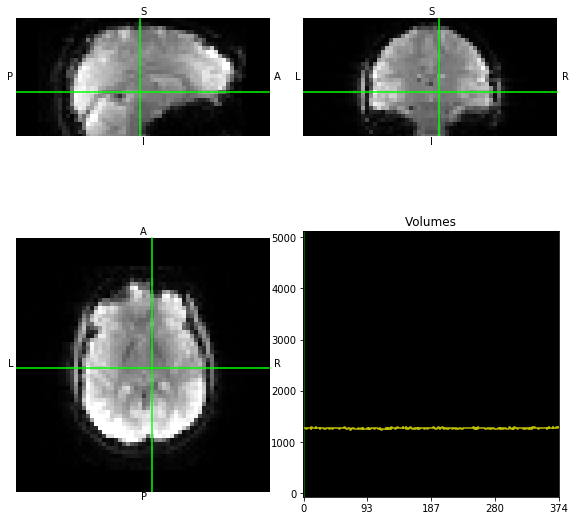

In [6]:
"""
Thoughts on what to do

1. Event times seem strict, so assume the unaccounted for time is either leading in or tailing the experiment
2. I read something about the data being processed to start at event 0.0, so I'll try calling the leftover a tail
3. If it doesn't seem right (test with neuroimage displaying) try splitting the difference in head+tail
"""

print("Image datatype: ", bold_img.get_data_dtype())
bold_img.orthoview()

In [7]:
display(events)

"""
Try and see if our understanding of the scans is aligned with the paper
"""
n_scans = 370  # sometimes the shape is 370, sometimes 375, I assume 370 is desired
scan_time = 1.6  # echo time appears to be included inside scan time, not extra
total_time = n_scans * scan_time  # 608.625 seconds, or a little past 10 minutes

durations = events.onset - events.shift(periods=1).onset
supposed_ending = events.onset.iloc[-1] + durations.median()  # 589.3
 
# Unaccounted for time
print(total_time - supposed_ending)

# <3s sounds good, >10s is concerning

,onset,duration,trial_type
0,0.0,24.10,food
1,40.1,24.06,nonfood
2,77.2,24.07,food
3,111.3,24.06,nonfood
4,143.3,24.06,food
5,179.4,24.07,nonfood
6,218.5,24.04,food
7,251.5,24.06,nonfood
8,289.6,10.00,break
9,299.6,24.07,food


2.699999999999932


In [8]:
"""
We'll have to use the events time to try to align scans with events
"""
scan_assignments = data.get_scan_assignments(bold_img.get_data().shape[-1], events)
print(list("{}: {}".format(k,len(v)) for k,v in scan_assignments.items()))

['food: 180', 'nonfood: 183', 'break: 7', 'unassigned: 5']


In [9]:
"""
On to the deep learning

First a quick check of our helper method which should hide the complexity of the scans from us
    data.get_machine_learning_data(layout=layout)
    
An f1 away from random would be very encouraging
"""
from src.models import sanity_check

skip_svc = True

if not skip_svc:
    results = sanity_check.test_ml_data(layout=layout, limit=400)
    display(results)

In [10]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import sampler

import torchvision
from torchvision import datasets, models, transforms


dtype = torch.float16


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cpu


In [11]:
# TODO definitely going to want to bake in the pytorch operations
ml_dataset = data.get_ml_dataset(layout=layout)
# ml_dataset.normalize()
# ml_dataset.flatten()
print(ml_dataset)

Assigning data from subject 01
Assigning data from subject 02
Assigning data from subject 03
MLDataset | Features: (30, 64, 64)  | Train: 762 | Validation: 218 | Test: 109


In [12]:
"""
ALRIGHT 
a looot of TODO here

working through them, first don't flatten, second can we default to using
pytorch as the data handler from the get go? transforms seem useful
"""


# inps = torch.arange(10 * 5, dtype=torch.float32).view(10, 5)
# tgts = torch.arange(10 * 5, dtype=torch.float32).view(10, 5)

# Adding np.newaxis for "channels" which this dataset doesn't seem to have
X_train = torch.from_numpy(ml_dataset.X_train[:,np.newaxis,:,:,:])
y_train = torch.from_numpy(ml_dataset.y_train)
X_val = torch.from_numpy(ml_dataset.X_val[:,np.newaxis,:,:,:])
y_val = torch.from_numpy(ml_dataset.y_val)
X_test = torch.from_numpy(ml_dataset.X_test[:,np.newaxis,:,:,:])
y_test = torch.from_numpy(ml_dataset.y_test)

# TODO this data is way too goddamn big, I need to downsample to survive
#  mini-batch x channels x [optional depth] x [optional height] x width.
#  orientation doesn't matter
X_train = F.interpolate(
    X_train, 
    scale_factor=3./4.,
)
X_val = F.interpolate(
    X_val, 
    scale_factor=3./4,
)
X_test = F.interpolate(
    X_test, 
    scale_factor=3./4,
)
print(X_train.shape, X_train.squeeze().shape)
train = TensorDataset(X_train, y_train)
val = TensorDataset(X_val, y_val)
test = TensorDataset(X_test, y_test)

features = np.prod(X_train.shape[2:])
print("Before downsampling: ", np.prod(ml_dataset.X_train.shape[1:]))
print("After: ", features)

torch.Size([762, 1, 22, 48, 48]) torch.Size([762, 22, 48, 48])
Before downsampling:  122880
After:  50688


In [13]:
"""DATASET LOADER FOR PYTORCH"""

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
data_transforms = transforms.Compose([
    transforms.ToTensor(),
#     transform.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

loader_train = DataLoader(
    train, 
    batch_size=64, 
#     transformer=data_transforms, TODO something like that
#     sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)),
)

loader_val = DataLoader(
    val, 
    batch_size=64, 
#     sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)),
)

loader_test = DataLoader(
    test, 
    batch_size=64,
)

In [14]:
"""HELPER METHODS"""

print_every = 1

def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print("epoch", e)
        for t, (x, y) in enumerate(loader_train):
            print("timestep", t, (x.shape, y.shape))
            # TODO float32? use x.double()?
            
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
                
            print(x.shape, y.shape)
            scores = model(x)
            print("OKAY")
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()
                
def check_accuracy_part34(loader, model):
    print('Checking accuracy on validation set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            # TODO fucking dtypes
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
     
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)
    
test_flatten()

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


In [15]:
"""Sequential TEST

Ah okay, huge fucking investigation on loss

look at other examples of handling pytorch anyhow

"""
hidden_layer_size = 4000
learning_rate = 1e-2
num_classes = 2

model = nn.Sequential(
    Flatten(),
    # TODO jesus christ the allocation here is massive, I need to shrink something
    nn.Linear(features, hidden_layer_size),  
    nn.ReLU(),
    nn.Linear(hidden_layer_size, num_classes),
)

optimizer = optim.SGD(
    model.parameters(), 
    lr=learning_rate,
    momentum=0.9, 
    nesterov=True,
)

# train_part34(model, optimizer)

In [17]:
learning_rate = 1e-2


factor = 8
in_channel = 1
channel_1 = 4 * factor
channel_2 = 8 * factor
channel_3 = 8 * factor
channel_4 = 16 * factor


# torch.nn.Conv3d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')

model = nn.Sequential(
#     nn.Conv3d(in_channel, channel_1, kernel_size=7, stride=2, padding=3),
    nn.Conv3d(in_channel, channel_1, kernel_size=7, stride=2, padding=3),
    nn.ReLU(),
    nn.Conv3d(channel_1, channel_2, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool3d(kernel_size=2),
    nn.Dropout(p=0.4),
    
    nn.Conv3d(channel_2, channel_3, kernel_size=5, stride=2, padding=2),
    nn.ReLU(),
    nn.Conv2d(channel_3, channel_4, kernel_size=3, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Dropout(p=0.4),

    Flatten(),
    nn.Linear(1152, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes),
)

optimizer = optim.SGD(
    model.parameters(), 
    lr=learning_rate,
    momentum=0.9, 
    nesterov=True,
)

train_part34(model, optimizer, epochs=1)

# RuntimeError: Expected 4-dimensional input for 4-dimensional weight 64 64 5 5, but got 5-dimensional input of size [64, 64, 5, 12, 12] instead

epoch 0
timestep 0 (torch.Size([64, 1, 22, 48, 48]), torch.Size([64]))
torch.Size([64, 1, 22, 48, 48]) torch.Size([64])


RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 6488064000 bytes. Error code 12 (Cannot allocate memory)


In [ ]:
# Available Modalities : T1w, bold
# TODO need to understand what the difference is, can I just use one?

from nilearn import plotting

# img_path = os.path.join(os.getcwd(), ds_path, 'sub-01', 'func', b_img.filename)
# plotting.plot_img(nibabel_b_img)

# layout.to_df().path.values


In [ ]:
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

# TODO shit, the image does not seem to fit at all.

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

In [ ]:
banana
# TODO use nilearn?

from nilearn.datasets import fetch_haxby
data_files = fetch_haxby()

# Load behavioral data
import pandas as pd
behavioral = pd.read_csv(data_files.session_target[0], sep=" ")

# Restrict to face and house conditions
conditions = behavioral['labels']
condition_mask = conditions.isin(['face', 'house'])

# Split data into train and test samples, using the chunks
condition_mask_train = (condition_mask) & (behavioral['chunks'] <= 6)
condition_mask_test = (condition_mask) & (behavioral['chunks'] > 6)

# Apply this sample mask to X (fMRI data) and y (behavioral labels)
# Because the data is in one single large 4D image, we need to use
# index_img to do the split easily
from nilearn.image import index_img
func_filenames = data_files.func[0]
X_train = index_img(func_filenames, condition_mask_train)
X_test = index_img(func_filenames, condition_mask_test)
y_train = conditions[condition_mask_train]
y_test = conditions[condition_mask_test]

# Compute the mean epi to be used for the background of the plotting
from nilearn.image import mean_img
background_img = mean_img(func_filenames)

In [ ]:
background_img.shape

In [ ]:
from torchvision.models import vgg

model = vgg.vgg11()
model

In [ ]:
model.train?

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

import nibabel as nib
from nibabel.testing import data_path
from nilearn import image
from nilearn import plotting


img_path = "/home/evan/Downloads/ds000221_R1.0.0/sub-010004/ses-02/func/sub-010004_ses-02_task-rest_acq-AP_run-01_bold.nii.gz"
# img_path = os.path.join(data_path, 'example4d.nii.gz')
# img = nib.load(img_path)
# # print(img)
# print(img.shape)

# plotting.plot_img(example_filename)

# img3d = image.index_img(img_path, 0)
# print(img3d.shape)
# plotting.plot_stat_map(img3d)
# plotting.plot_img(img3d)
# plt.show()

print("bigboi")
all_images = list(image.iter_img(img_path))
for img in all_images[:5]:
    # img is now an in-memory 3D img
    plotting.plot_stat_map(img, threshold=3, display_mode="z", cut_coords=1, colorbar=False)
plotting.show()
